In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns


from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

sns.set_theme()

rmse
rmse
rmse
rmse
rmse
rmse
rmse
rmse
rmse
rmse
rmse
rmse
rmse
rmse
rmse
rmse


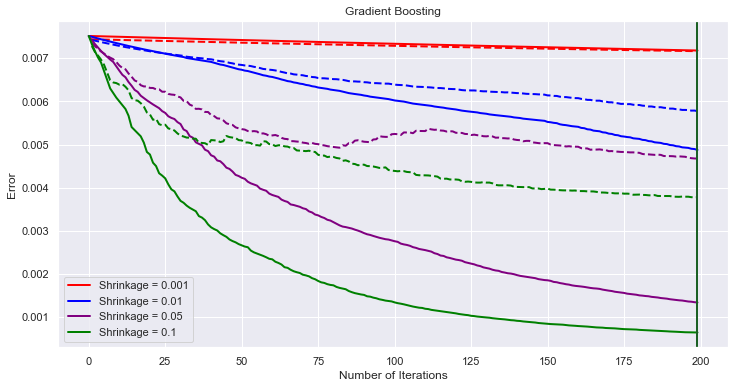

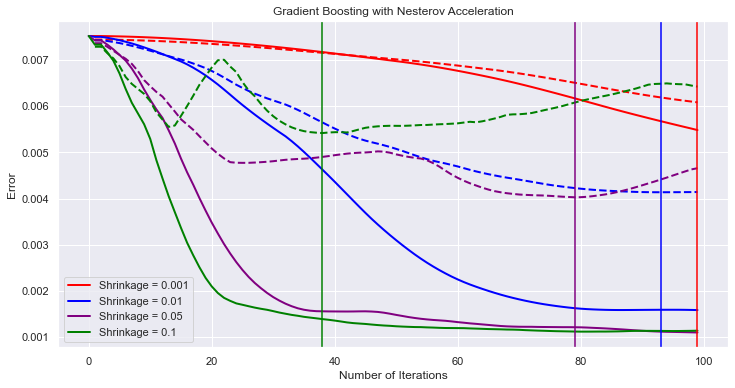

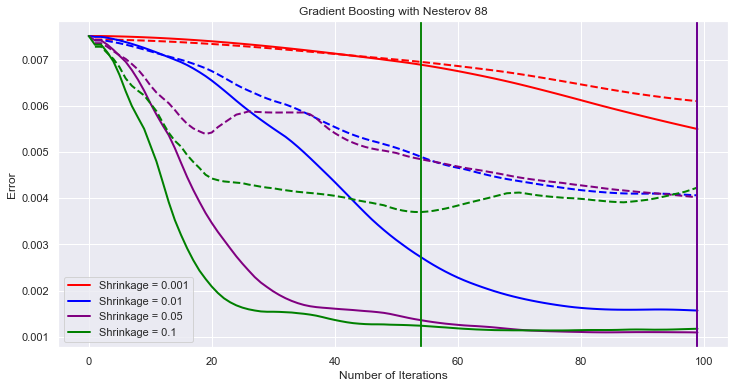

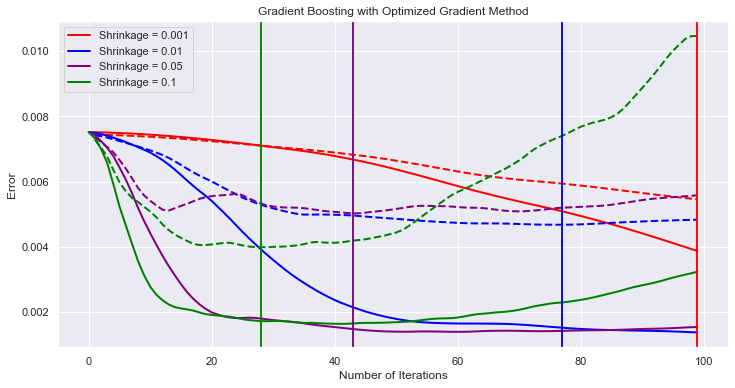

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

sns.set_theme()


def get_perm(n_all,n_sub):
    perm = list(range(0, n_all))
    perm = random.sample(perm, n_sub)
    return(perm)

def agb(x,y,train_fraction=0.75,n_trees=500,shrinkage=0.01,
        distribution="gaussian",depth_tree=4,n_minobsinnode = 10,
        criterion = 'mse',ogm = False, nesterov_88 = False, nesterov=False,subsample=1, error_type = 'rmse'):

    n = x.shape[0]
    n_trees = n_trees +1
    n_train = int(round(n*train_fraction))
    n_valid = n-n_train

    x_train = x.iloc[:n_train]
    x_valid = x.iloc[n_train:]

    y_train = y.iloc[:n_train]
    y_valid = y.iloc[n_train:]

    err_train = np.zeros((n_trees-1,),dtype=np.float64) #rep(0,n.trees)
    err_valid = np.zeros((n_trees-1,),dtype=np.float64)


    if subsample < 1:
        n_sub  = int(round(n_train*subsample))
        scf    = get_perm(n_train,n_sub)
        sub_x_train = x_train.iloc[scf]
        sub_y_train = y_train.iloc[scf]
        fitted = pd.DataFrame(np.zeros((n_train,n_trees),dtype=np.float64))
        prev_valid = pd.DataFrame(np.zeros((n_valid,n_trees),dtype=np.float64))
        g_fitted   = fitted.copy()
        g_prev_valid = prev_valid.copy()
        fitted.iloc[:,0] = np.mean(y_train)
        prev_valid.iloc[:,0] = np.mean(y_valid)
        g_fitted.iloc[:,0] = fitted.iloc[:,0]
        g_prev_valid.iloc[:,0] = prev_valid.iloc[:,0]
        if error_type == 'rmse':
            err_train[0] = np.sqrt(np.mean((y_train-fitted.iloc[:,0])**2))
            err_valid[0] = np.sqrt(np.mean((y_valid-prev_valid.iloc[:,0])**2))
        elif error_type == 'mse':
            err_train[0] = np.mean((y_train-fitted.iloc[:,0])**2)
            err_valid[0] = np.mean((y_valid-prev_valid.iloc[:,0])**2)
        elif error_type == 'abs':
            err_train[0] = np.mean(np.abs(y_train-fitted.iloc[:,0]))
            err_valid[0] = np.mean(np.abs(y_valid-prev_valid.iloc[:,0]))
        data_boucle  = sub_x_train.copy()
        data_boucle.loc[:,"U"] = 0
    else :
        print(error_type)
        fitted       = pd.DataFrame(np.zeros((n_train,n_trees),dtype=np.float64))
        prev_valid   = pd.DataFrame(np.zeros((n_valid,n_trees),dtype=np.float64))
        
        g_fitted     = fitted.copy()
        g_prev_valid = prev_valid.copy()
        fitted.iloc[:,0]  = np.mean(y_train)
        prev_valid.iloc[:,0] = np.mean(y_valid)
        g_fitted.iloc[:,0] = fitted.iloc[:,0]
        g_prev_valid.iloc[:,0] = prev_valid.iloc[:,0]
        if error_type == 'rmse':
            err_train[0] = np.sqrt(np.mean((y_train-fitted.iloc[:,0])**2))
            err_valid[0] = np.sqrt(np.mean((y_valid-prev_valid.iloc[:,0])**2))
        elif error_type == 'mse':
            err_train[0] = np.mean((y_train-fitted.iloc[:,0])**2)
            err_valid[0] = np.mean((y_valid-prev_valid.iloc[:,0])**2)
        elif error_type == 'abs':
            err_train[0] = np.mean(np.abs(y_train-fitted.iloc[:,0]))
            err_valid[0] = np.mean(np.abs(y_valid-prev_valid.iloc[:,0]))

        data_boucle  = x_train.copy()
        data_boucle.loc[:,"U"] = 0

    tree_ctrl = {'max_depth': depth_tree, 'min_samples_split': n_minobsinnode
                ,'criterion':criterion, 'splitter':'best'}

    tree = DecisionTreeRegressor(**tree_ctrl)
    tree.fit(x_train,y_train)

    lamb  = np.zeros((n_trees,),dtype=np.float64)
    gamma = np.zeros((n_trees,),dtype=np.float64)
    theta = np.zeros((n_trees,),dtype=np.float64)
    gamma[0] = 1
    theta[0] = 1

    #coefficients barzilai
    
    coeff_s_fitted = pd.DataFrame(np.zeros((n_train,n_trees),dtype=np.float64))
    coeff_s_valid = pd.DataFrame(np.zeros((n_train,n_trees),dtype=np.float64))
    
    coeff_y_fitted = pd.DataFrame(np.zeros((n_train,n_trees),dtype=np.float64))
    coeff_y_valid = pd.DataFrame(np.zeros((n_train,n_trees),dtype=np.float64))
                
    coeff_eta_fitted = np.zeros((n_trees,),dtype=np.float64)
    coeff_eta_fitted[0] = 0.01 
    coeff_eta_valid = np.zeros((n_trees,),dtype=np.float64)
    coeff_eta_valid[0] = 0.01 
    
    super_U = pd.DataFrame(np.zeros((n_train,n_trees),dtype=np.float64))
    
    coeff_grad_fitted = pd.DataFrame(np.zeros((8950,n_trees),dtype=np.float64))
    coeff_grad_valid = pd.DataFrame(np.zeros((2984,n_trees),dtype=np.float64))
    
    U_1 = 0
    
    
    for i in range(1,n_trees):
        lamb[i] = 0.5*(1+math.sqrt(1+4*lamb[i-1]**2))

    for i in range(1,n_trees-1):
        theta[i] = 0.5*(1+math.sqrt(1+4*theta[i-1]**2))
    theta[n_trees-1] = 0.5*(1+math.sqrt(1+8*theta[n_trees-2]**2))
    
    if distribution=="gaussian":
        #n_trees-1
        for i in range(1,n_trees-1):
            
            if (nesterov==True and ogm == False and nesterov_88 == False  and subsample==1):
                gamma[i] = (1-lamb[i])/lamb[i+1]
                U        = y_train-g_fitted.iloc[:,i-1]
                #data_boucle.loc[:,"U"] = U
                tree = DecisionTreeRegressor(**tree_ctrl)
                tree.fit(x_train,U)
                #data_boucle1 = data_boucle
                
                #ici il y a deux X : X_fitted et X_prev (F dans AGB)
                # Equivalent de x_t+1 = y_t + alpha*gradf(yt)
                
                fitted.iloc[:,i]     = g_fitted.iloc[:,i-1]     + shrinkage*tree.predict(x_train) 
                prev_valid.iloc[:,i] = g_prev_valid.iloc[:,i-1] + shrinkage*tree.predict(x_valid)
                
                
                #ici il y a deux Y : Y_fitted et Y_prev (G dans AGB)
                # Equivalent de yt+1 = (1−gamma_t) * xt+1 + gamma_t * xt

                g_fitted.iloc[:,i]   = (1-gamma[i-1])*fitted.iloc[:,i]+gamma[i-1]*fitted.iloc[:,i-1] 
                g_prev_valid.iloc[:,i] = (1-gamma[i-1])*prev_valid.iloc[:,i]+gamma[i-1]*prev_valid.iloc[:,i-1]
                
                if error_type == 'rmse':
                    err_train[i] = np.sqrt(np.mean((y_train.values-fitted.iloc[:,i].values)**2))
                    err_valid[i] = np.sqrt(np.mean((y_valid.values-prev_valid.iloc[:,i].values)**2))
                elif error_type == 'mse':
                    err_train[i] = np.mean((y_train.values-fitted.iloc[:,i].values)**2)
                    err_valid[i] = np.mean((y_valid.values-prev_valid.iloc[:,i].values)**2)
                elif error_type == 'abs':
                    err_train[i] = np.mean(np.abs(y_train.values-fitted.iloc[:,i].values))
                    err_valid[i] = np.mean(np.abs(y_valid.values-prev_valid.iloc[:,i].values))

            elif(nesterov==False and ogm == False and nesterov_88 == False  and subsample==1):
                U = y_train-fitted.iloc[:,i-1]
                data_boucle.loc[:,"U"] = U
                tree = DecisionTreeRegressor(**tree_ctrl)
                tree.fit(x_train,U)
                #data_boucle1 = data_boucle
                fitted.iloc[:,i] = fitted.iloc[:,i-1] + shrinkage*tree.predict(x_train)
                prev_valid.iloc[:,i] = prev_valid.iloc[:,i-1] + shrinkage*tree.predict(x_valid)
                if error_type == 'rmse':
                    err_train[i] = np.sqrt(np.mean((y_train.values-fitted.iloc[:,i].values)**2))
                    err_valid[i] = np.sqrt(np.mean((y_valid.values-prev_valid.iloc[:,i].values)**2))
                elif error_type == 'mse':
                    err_train[i] = np.mean((y_train.values-fitted.iloc[:,i].values)**2)
                    err_valid[i] = np.mean((y_valid.values-prev_valid.iloc[:,i].values)**2)
                elif error_type == 'abs':
                    err_train[i] = np.mean(np.abs(y_train.values-fitted.iloc[:,i].values))
                    err_valid[i] = np.mean(np.abs(y_valid.values-prev_valid.iloc[:,i].values))
                    
            elif (nesterov==False and ogm == True and nesterov_88 == False and subsample == 1):
                
                gamma[i] = - i/(i+3)
                U        = y_train-g_fitted.iloc[:,i-1]
                #data_boucle.loc[:,"U"] = U
                tree = DecisionTreeRegressor(**tree_ctrl)
                tree.fit(x_train,U)
                #data_boucle1 = data_boucle
                
                #ici il y a deux X : X_fitted et X_prev (F dans AGB)
                # Equivalent de x_t+1 = y_t + alpha*gradf(yt)
                
                fitted.iloc[:,i]     = g_fitted.iloc[:,i-1]     + shrinkage*tree.predict(x_train) 
                prev_valid.iloc[:,i] = g_prev_valid.iloc[:,i-1] + shrinkage*tree.predict(x_valid)
                
                
                #ici il y a deux Y : Y_fitted et Y_prev (G dans AGB)
                # Equivalent de yt+1 = (1−gamma_t) * xt+1 + gamma_t * xt

                g_fitted.iloc[:,i]   = fitted.iloc[:,i] + ((theta[i] - 1)/(theta[i+1])) *(fitted.iloc[:,i] - fitted.iloc[:,i - 1]) + \
                                        ((theta[i])/(theta[i+1])) * (fitted.iloc[:,i] - g_fitted.iloc[:,i - 1])
                g_prev_valid.iloc[:,i] = prev_valid.iloc[:,i] + ((theta[i] - 1)/(theta[i+1])) * (prev_valid.iloc[:,i] - prev_valid.iloc[:,i-1])  + \
                                        ((theta[i])/(theta[i+1])) * (prev_valid.iloc[:,i] - g_prev_valid.iloc[:,i - 1])
            
                if error_type == 'rmse':
                    err_train[i] = np.sqrt(np.mean((y_train.values-fitted.iloc[:,i].values)**2))
                    err_valid[i] = np.sqrt(np.mean((y_valid.values-prev_valid.iloc[:,i].values)**2))
                elif error_type == 'mse':
                    err_train[i] = np.mean((y_train.values-fitted.iloc[:,i].values)**2)
                    err_valid[i] = np.mean((y_valid.values-prev_valid.iloc[:,i].values)**2)
                elif error_type == 'abs':
                    err_train[i] = np.mean(np.abs(y_train.values-fitted.iloc[:,i].values))
                    err_valid[i] = np.mean(np.abs(y_valid.values-prev_valid.iloc[:,i].values))
                
            elif (nesterov==False and ogm == False and nesterov_88 == True and subsample == 1):
                
                gamma[i] = - i/(i+3)
                U        = y_train-g_fitted.iloc[:,i-1]
                #data_boucle.loc[:,"U"] = U
                tree = DecisionTreeRegressor(**tree_ctrl)
                tree.fit(x_train,U)
                #data_boucle1 = data_boucle
                
                #ici il y a deux X : X_fitted et X_prev (F dans AGB)
                # Equivalent de x_t+1 = y_t + alpha*gradf(yt)
                
                fitted.iloc[:,i]     = g_fitted.iloc[:,i-1]     + shrinkage*tree.predict(x_train) 
                prev_valid.iloc[:,i] = g_prev_valid.iloc[:,i-1] + shrinkage*tree.predict(x_valid)
                
                
                #ici il y a deux Y : Y_fitted et Y_prev (G dans AGB)
                # Equivalent de yt+1 = (1−gamma_t) * xt+1 + gamma_t * xt

                g_fitted.iloc[:,i]   = (1-gamma[i-1])*fitted.iloc[:,i]+gamma[i-1]*fitted.iloc[:,i-1] 
                g_prev_valid.iloc[:,i] = (1-gamma[i-1])*prev_valid.iloc[:,i]+gamma[i-1]*prev_valid.iloc[:,i-1]
                
                if error_type == 'rmse':
                    err_train[i] = np.sqrt(np.mean((y_train.values-fitted.iloc[:,i].values)**2))
                    err_valid[i] = np.sqrt(np.mean((y_valid.values-prev_valid.iloc[:,i].values)**2))
                elif error_type == 'mse':
                    err_train[i] = np.mean((y_train.values-fitted.iloc[:,i].values)**2)
                    err_valid[i] = np.mean((y_valid.values-prev_valid.iloc[:,i].values)**2)
                elif error_type == 'abs':
                    err_train[i] = np.mean(np.abs(y_train.values-fitted.iloc[:,i].values))
                    err_valid[i] = np.mean(np.abs(y_valid.values-prev_valid.iloc[:,i].values)) 
            
            
            if err_valid[i]>=100:
                n_trees = i
                err_train = err_train[0:i]
                err_valid = err_valid[0:i]
                break
    
    result = {}
    result = {'error_train':err_train,'error_valid':err_valid}

    return result

if __name__ == "__main__":
    data = pd.read_csv("data.csv",header=None)
    x_train = data.drop([17],axis=1)
    y_train = data[17]

       
    agb_ogm_1 = agb(x_train,y_train,ogm=True,n_trees=100,subsample=1, shrinkage = 0.001)
    agb_ogm_2 = agb(x_train,y_train,ogm=True,n_trees=100,subsample=1, shrinkage = 0.01)
    agb_ogm_3 = agb(x_train,y_train,ogm=True,n_trees=100,subsample=1, shrinkage = 0.05)
    agb_ogm_4 = agb(x_train,y_train,ogm=True,n_trees=100,subsample=1, shrinkage = 0.1)
    
    agb_nesterov_1 = agb(x_train,y_train,nesterov=True,n_trees=100,subsample=1, shrinkage = 0.001)
    agb_nesterov_2 = agb(x_train,y_train,nesterov=True,n_trees=100,subsample=1, shrinkage = 0.01)
    agb_nesterov_3 = agb(x_train,y_train,nesterov=True,n_trees=100,subsample=1, shrinkage = 0.05)
    agb_nesterov_4 = agb(x_train,y_train,nesterov=True,n_trees=100,subsample=1, shrinkage = 0.1)
    
    agb_nesterov88_1 = agb(x_train,y_train,nesterov_88=True,n_trees=100,subsample=1, shrinkage = 0.001)
    agb_nesterov88_2 = agb(x_train,y_train,nesterov_88=True,n_trees=100,subsample=1, shrinkage = 0.01)
    agb_nesterov88_3 = agb(x_train,y_train,nesterov_88=True,n_trees=100,subsample=1, shrinkage = 0.05)
    agb_nesterov88_4 = agb(x_train,y_train,nesterov_88=True,n_trees=100,subsample=1, shrinkage = 0.1)

    vanilla_gb_1 = agb(x_train,y_train,n_trees=200,subsample=1,shrinkage = 0.001)
    vanilla_gb_2 = agb(x_train,y_train,n_trees=200,subsample=1,shrinkage = 0.01)
    vanilla_gb_3 = agb(x_train,y_train,n_trees=200,subsample=1,shrinkage = 0.05)
    vanilla_gb_4 = agb(x_train,y_train,n_trees=200,subsample=1,shrinkage = 0.1)
    
    
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(vanilla_gb_1['error_train'], color="red", linewidth=2, label= "Shrinkage = 0.001")
    plt.plot(vanilla_gb_1['error_valid'], '--', color="red", linewidth=2)
    
    plt.plot(vanilla_gb_2['error_train'], color="blue", linewidth=2, label= "Shrinkage = 0.01")
    plt.plot(vanilla_gb_2['error_valid'], '--', color="blue", linewidth=2)
    
    plt.plot(vanilla_gb_3['error_train'], color="purple", linewidth=2, label= "Shrinkage = 0.05")
    plt.plot(vanilla_gb_3['error_valid'], '--', color="purple", linewidth=2)
    
    plt.plot(vanilla_gb_4['error_train'], color="green", linewidth=2, label= "Shrinkage = 0.1")
    plt.plot(vanilla_gb_4['error_valid'], '--', color="green", linewidth=2)
    
    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel('Error')
    plt.axvline(x=np.nanargmin(vanilla_gb_1['error_valid']), color="red")
    plt.axvline(x=np.nanargmin(vanilla_gb_2['error_valid']), color="blue")
    plt.axvline(x=np.nanargmin(vanilla_gb_3['error_valid']), color="purple")
    plt.axvline(x=np.nanargmin(vanilla_gb_4['error_valid']), color="green")

    plt.title('Gradient Boosting')
    ax.legend();
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(agb_nesterov_1['error_train'], color="red", linewidth=2, label= "Shrinkage = 0.001")
    plt.plot(agb_nesterov_1['error_valid'], '--', color="red", linewidth=2)
    
    plt.plot(agb_nesterov_2['error_train'], color="blue", linewidth=2, label= "Shrinkage = 0.01")
    plt.plot(agb_nesterov_2['error_valid'], '--', color="blue", linewidth=2)
    
    plt.plot(agb_nesterov_3['error_train'], color="purple", linewidth=2, label= "Shrinkage = 0.05")
    plt.plot(agb_nesterov_3['error_valid'], '--', color="purple", linewidth=2)
    
    plt.plot(agb_nesterov_4['error_train'], color="green", linewidth=2, label= "Shrinkage = 0.1")
    plt.plot(agb_nesterov_4['error_valid'], '--', color="green", linewidth=2)
    
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error')
    
    plt.axvline(x=np.nanargmin(agb_nesterov_1['error_valid']), color="red")
    plt.axvline(x=np.nanargmin(agb_nesterov_2['error_valid']), color="blue")
    plt.axvline(x=np.nanargmin(agb_nesterov_3['error_valid']), color="purple")
    plt.axvline(x=np.nanargmin(agb_nesterov_4['error_valid']), color="green")
    
    plt.title('Gradient Boosting with Nesterov Acceleration')
    ax.legend();
    plt.show()

    
    
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(agb_nesterov88_1['error_train'], color="red", linewidth=2, label= "Shrinkage = 0.001")
    plt.plot(agb_nesterov88_1['error_valid'], '--', color="red", linewidth=2)
    
    plt.plot(agb_nesterov88_2['error_train'], color="blue", linewidth=2, label= "Shrinkage = 0.01")
    plt.plot(agb_nesterov88_2['error_valid'], '--', color="blue", linewidth=2)
    
    plt.plot(agb_nesterov88_3['error_train'], color="purple", linewidth=2, label= "Shrinkage = 0.05")
    plt.plot(agb_nesterov88_3['error_valid'], '--', color="purple", linewidth=2)
    
    plt.plot(agb_nesterov88_4['error_train'], color="green", linewidth=2, label= "Shrinkage = 0.1")
    plt.plot(agb_nesterov88_4['error_valid'], '--', color="green", linewidth=2)
    
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error')
    
    plt.axvline(x=np.nanargmin(agb_nesterov88_1['error_valid']), color="red")
    plt.axvline(x=np.nanargmin(agb_nesterov88_2['error_valid']), color="blue")
    plt.axvline(x=np.nanargmin(agb_nesterov88_3['error_valid']), color="purple")
    plt.axvline(x=np.nanargmin(agb_nesterov88_4['error_valid']), color="green")
    
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error')
    
    plt.axvline(x=np.nanargmin(agb_nesterov88_1['error_valid']), color="red")
    plt.axvline(x=np.nanargmin(agb_nesterov88_2['error_valid']), color="blue")
    plt.axvline(x=np.nanargmin(agb_nesterov88_3['error_valid']), color="purple")
    plt.axvline(x=np.nanargmin(agb_nesterov88_4['error_valid']), color="green")
    plt.title('Gradient Boosting with Nesterov 88')
    ax.legend();
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(agb_ogm_1['error_train'], color="red", linewidth=2, label= "Shrinkage = 0.001")
    plt.plot(agb_ogm_1['error_valid'], '--', color="red", linewidth=2)
    
    plt.plot(agb_ogm_2['error_train'], color="blue", linewidth=2, label= "Shrinkage = 0.01")
    plt.plot(agb_ogm_2['error_valid'], '--', color="blue", linewidth=2)
    
    plt.plot(agb_ogm_3['error_train'], color="purple", linewidth=2, label= "Shrinkage = 0.05")
    plt.plot(agb_ogm_3['error_valid'], '--', color="purple", linewidth=2)
    
    plt.plot(agb_ogm_4['error_train'], color="green", linewidth=2, label= "Shrinkage = 0.1")
    plt.plot(agb_ogm_4['error_valid'], '--', color="green", linewidth=2)
    
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error')
    
    plt.axvline(x=np.nanargmin(agb_ogm_1['error_valid']), color="red")
    plt.axvline(x=np.nanargmin(agb_ogm_2['error_valid']), color="blue")
    plt.axvline(x=np.nanargmin(agb_ogm_3['error_valid']), color="purple")
    plt.axvline(x=np.nanargmin(agb_ogm_4['error_valid']), color="green")
    
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error')
    
    plt.axvline(x=np.nanargmin(agb_ogm_1['error_valid']), color="red")
    plt.axvline(x=np.nanargmin(agb_ogm_2['error_valid']), color="blue")
    plt.axvline(x=np.nanargmin(agb_ogm_3['error_valid']), color="purple")
    plt.axvline(x=np.nanargmin(agb_ogm_4['error_valid']), color="green")
    plt.title('Gradient Boosting with Optimized Gradient Method')
    ax.legend();
    plt.show()
    

    '''
    agb(x_train,y_train,barzilai=True,n_trees=20,subsample=1, shrinkage=0.05)
    agb(x_train,y_train,nesterov=True,n_trees=20,subsample=1)
    '''
